In [1]:
import cdsapi
import climetlab as cml
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import geopy
import xarray as xr
import pandas as pd

import csv
import os
import pickle

import scipy
import sklearn 
from sklearn.cluster import KMeans

import seaborn as sns
import cartopy.crs as ccrs

import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Get single event data. Opens netCDF files stored on HPC to access daily ERA5 data. 

__variable__ - Select from t2m, tp, sf, u10, v10 (string) <br>
__state__ - Enter in state to gather data from (string) <br>
__date__ - Date to gather data from. Note HPC only contains data for dates in the dataset (Month-Date-Year) (XX-XX-XXX) <br>
__sample_x__ - Number of longitutde points to sample (in degrees) (int) <br>
__sample_y__ - Number of latitude points to sample (in degrees) (int) 

In [2]:
def get_event(variable,state,date,sample_x,sample_y,sample_interval):
    sd = date.split("-")
    month = sd[0]
    day = sd[1]
    year = sd[2]
    means = xr.open_dataset('../../../a/state_means/global_mean.nc')
    x = xr.open_dataset('../../../a/era5_data/' + date + '.nc')

    currLocation = geopandas.tools.geocode(state)
    lat = currLocation.geometry.y.values[0]
    lon = currLocation.geometry.x.values[0] + 360.

    state_mean = means.sel(latitude=slice(lat+sample_x,lat-sample_x), longitude=slice(lon-sample_x,lon+sample_x),time= year + '-' + month + '-01')
    # print(state_mean.sf)
    locate =  x.sel(latitude=slice(lat+sample_y,lat-sample_y), longitude=slice(lon-sample_y,lon+sample_y), time=year + '-' + month + '-' + day + '-' + 'T12:00:00')

    # cartopy

    

    lat_val = locate['latitude'].values
    lon_val = locate['longitude'].values

    [X,Y] = np.meshgrid(lon_val,lat_val)

    temp = locate[variable].values

    proj = ccrs.Mercator()

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection=proj)

    plt1 = ax.contourf(X, Y, temp, levels=100, cmap='nipy_spectral_r', transform=ccrs.PlateCarree())
    ax.set_title(state + " " + variable + " Contour Map " + str(date), fontsize=16)


    states = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(states, edgecolor='black')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # Following possibly depracated?
    # gl.xlabels_top = False
    # gl.ylabels_right = False


    gl.right_labels = False
    gl.top_labels = False
    gl.xlines = True; gl.xlocator = mticker.FixedLocator(np.linspace(-170, -50, 49)); gl.xformatter = LONGITUDE_FORMATTER; gl.xlabel_style = {'size':16, 'color':'black'}
    gl.ylines = True; gl.ylocator = mticker.FixedLocator(np.linspace(20, 65, 19)); gl.yformatter = LATITUDE_FORMATTER; gl.ylabel_style = {'size':16, 'color':'black'}


    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    pos = ax.get_position()
    cbar_ax.set_position([pos.x0 + pos.width + 0.01, pos.y0, 0.04, pos.height])
    cbar = plt.colorbar(plt1, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=16)

    plt.show()

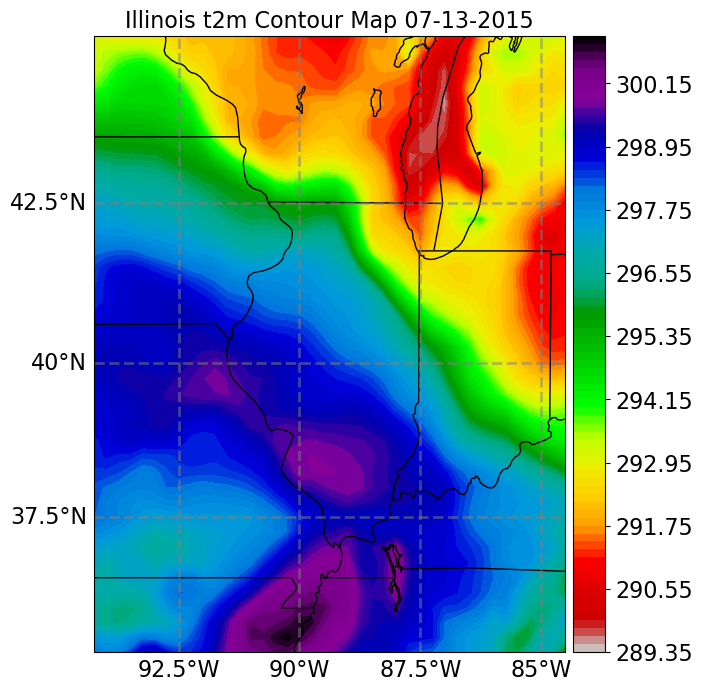

In [3]:
get_event('t2m',"Illinois", "07-13-2015", 5, 5, 1)

In [6]:
# cpc global unified gauge based analysis of daily precipitation